<a href="https://colab.research.google.com/github/Koar-create/Yang-Repository-CS/blob/main/W1D2T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **W1D2T2.ipynb**

Author: Zhixian Yang

Email: yangzhx28@mail2.sysu.edu.cn

GitHub: https://github.com/koar-create

Date created: July 12th, 2023

Last modified: July 13th, 2023

<br><br>

---

<br><br>

## **Description**
This document is a Jupyter Notebook designed for an exercise derived from the "Computational Tools for Climate Science 2023" course offered by Climatematch Academy. The code presented here comprises a combination of materials provided in the course and code obtained from online sources.

**_<font color='E00000' size=6>install dependencies, import related packages</font>_**

---

**_<font face='Times New Roman' size=4 >no comments</font>_**

In [ ]:
!pip install cftime
!pip install xarray
!pip install cartopy

!pip install cdsapi
!pip install pythia_datasets
# !pip install zarr
# !pip install intake
# !pip install intake-xarray[zarr]
# !pip install intake-xarray[complete]

In [ ]:
# # ↓ literally "doesn't work"
# import intake_xarray
# from intake import open_catalog
# cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/atmosphere.yaml")
# ERA5 = cat["era5_hourly_reanalysis_single_levels_sa"].to_dask()
# ERA5

In [ ]:
import time, cftime
import os, sys, warnings
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)

import cdsapi
from pythia_datasets import DATASETS

In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!apt-get install python3-cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
import cartopy.io.shapereader as shapereader

In [ ]:
warnings.filterwarnings('ignore')

**_<font color='E00000' size=7>part 1</font>_**

---

**_<font face='Times New Roman' size=4 >downloading data from ECMWF using cdsapi package</font>_**

In [ ]:
!echo "url: https://cds.climate.copernicus.eu/api/v2" > $HOME/.cdsapirc
!echo "key: *erased" >> $HOME/.cdsapirc
!cat $HOME/.cdsapirc

In [ ]:
mode     = 'SH'
filename = f"2016-{mode}-JanJul.nc"
extra_flag = "no"
line1 = {'LH':             'land' , 'LM':            'land-monthly-means',
         'SH':   'single-levels'  , 'SM':   'single-levels-monthly-means',
         'PH': 'pressure-levels'  , 'PM': 'pressure-levels-monthly-means', }
product_type = {'H': 'reanalysis',
                'M': 'monthly_averaged_reanalysis', }
u = {'L': '10m_',
     'S': '10m_',
     'P':     '', }
v = {'L': '10m_',
     'S': '10m_',
     'P':     '', }
T = {'L':        'skin_',
     'S': 'sea_surface_',
     'P':             '', }
precip = {'L': 'total_precipitation',
          'S': 'total_precipitation',
          'P':                    '', }
'''
↑ don't change
↓ customize
'''
pressure_level = {'pressure_level': ['500', '1000']}
# dict_day = {'day': [f"{i:02}" for i in range(1, 31+1, 1)]}
dict_day = {'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
                    '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                    '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', ], }

extra_variables = {"yes": {'L': ['2m_dewpoint_temperature', '2m_temperature', 'surface_pressure', ],
                           'S': ['2m_dewpoint_temperature', '2m_temperature', 'surface_pressure', 'mean_sea_level_pressure', ],
                           'P': ['divergence', 'fraction_of_cloud_cover', 'geopotential', 'ozone_mass_mixing_ratio', 'potential_vorticity', 'relative_humidity', 'specific_cloud_ice_water_content', 'specific_cloud_liquid_water_content', 'specific_humidity', 'specific_rain_water_content', 'specific_snow_water_content', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity', 'vorticity', ], },
                   "no": {'L': [], 'S': [], 'P': [], }}

In [ ]:
c = cdsapi.Client()
retrieve_dict = {
        'product_type': product_type[mode[-1]],
        'variable': [
            u[mode[0]]+'u_component_of_wind', v[mode[0]]+'v_component_of_wind', T[mode[0]]+'temperature', precip[mode[0]],
        ] + extra_variables[extra_flag][mode[0]],
        'year': [
            '2016',
        ],
        'month': [
            '01', '07',
        ],
        'time': [
            '00:00', '12:00'
        ],
        'format': 'netcdf',
        'area': [
            90, -180, -90, 180,
        ],
    }
if mode == 'LH':
   retrieve_dict = {key: value for key, value in retrieve_dict.items() if key not in {'product_type': []}}
if mode[0] == 'P':
  retrieve_dict.update(pressure_level)
if mode[1] == 'H':
  retrieve_dict.update(dict_day)
c.retrieve(
    'reanalysis-era5-'+line1[mode],
    retrieve_dict,
    filename)

**_<font color='E00000' size=7>part 2</font>_**

---

**_<font face='Times New Roman' size=4 >re-setting attributes of DataArray objects after calculation</font>_**

In [ ]:
ds = xr.open_dataset(filename)
ds.sst
# ds.tp

In [ ]:
ds = xr.open_dataset(filename)
ds['sst'] = ds.sst - 273.16
ds['tp']  = ds.tp * 1000
ds.sst.attrs['units'] = 'K'
ds.sst.attrs['long_name'] = 'Sea surface temperature'
ds.tp.attrs['units'] = 'mm'
ds.tp.attrs['long_name'] = 'Total precipitation'
ds
# coarsen_ds = ds.coarsen(time=1, latitude=7, longitude=8, level=1).mean()
# coarsen_ds

**_<font color='E00000' size=7>part 3, 4 & 5</font>_**

---

* <font size=4>using </font>
 <font face='Monospace' color='D434CD' size=4>plt.subplots()</font>
 <font size=4> with several prescribed parameters to create figure and axes objects;</font>
* <font size=4>using different ways (</font>
 <font face='Monospace' color='D434CD' size=4>XRDA.where(condi, drop=True), XRDA.sel(time=condi), XRDA[condi, :, :]</font>
 <font size=4>) to index DataArray objects;</font>
* <font size=4>using </font>
 <font face='Monospace' color='D434CD' size=4>latitude=slice(big_value, small_value)</font>
 <font size=4> while producing data from ECMWF.</font>

In [ ]:
proj = ccrs.Robinson(central_longitude=120.)
# proj = ccrs.PlateCarree(central_longitude=120.)
# proj = ccrs.PlateCarree(central_longitude=180.)
# proj = ccrs.LambertConformal(central_longitude=120, central_latitude=25, standard_parallels=(30, 60))
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': proj})
time_index = (ds.time.dt.month==7)&(ds.time.dt.day==30)&(ds.time.dt.hour==12)
ds.u10.sel(time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(vmin=-12, vmax=12, ax=axes[0, 0], cmap='viridis')
ds.v10.sel(time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(vmin=-12, vmax=12, ax=axes[0, 1], cmap='viridis')
ds.sst.sel(time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(vmin= -2, vmax=30, ax=axes[1, 0], cmap='coolwarm')
ds.tp.sel( time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(ax=axes[1, 1], cmap='jet')
plt.show()

**_<font color='E00000' size=7>part 6 & 7</font>_**

---

* <font size=4>calculating daily average values by using </font><font face='Monospace' color='D434CD' size=4>resample()</font><font size=4> method</font>
* <font size=4>calculating synoptic anomalies by subtracting monthly average value from daily average values </font>

**_<font size=4>* synoptic_anomalies = daily_mean - monthly_mean</font>_**

In [ ]:
ds_jan = ds.where(ds.time.dt.month==1, drop=True)
ds_jan

In [ ]:
ds_synoptic = ds_jan.resample({'time': '1D'}).mean('time').isel(time=[0, 5, 10, 15])
ds_mm = ds_jan.mean('time')
ds_synoptic = ds_synoptic - ds_mm

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': proj})
time_index = (ds_synoptic.time.dt.month==1)&(ds_synoptic.time.dt.day==1)&(ds_synoptic.time.dt.hour==0)
ds_synoptic.u10.sel(time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(ax=axes[0, 0], cmap='viridis')
ds_synoptic.v10.sel(time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(ax=axes[0, 1], cmap='viridis')
ds_synoptic.sst.sel(time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(ax=axes[1, 0], cmap='coolwarm')
ds_synoptic.tp.sel( time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(ax=axes[1, 1], cmap='jet')
plt.show()

**_<font color='E00000' size=7>part 8 & 9</font>_**

---

* <font size=4>calculating local time without changing data type</font>
* <font size=4>used functions/methods: </font>
 <font face='Monospace' color='D434CD' size=4>np.datetime_as_string(), datetime.strptime(), np.datetime64()</font>

In [ ]:
A = np.datetime_as_string(ds_synoptic.time.data, unit='s')  # array of np.datetime64[ns] -> array of str
date = A[0]
B = timedelta(hours=8) + datetime.strptime(date, '%Y-%m-%dT%H:%M:%S')  # str -> datetime.datetime object
C = np.datetime64(B, 'ns')  # datetime.datetime object -> np.datetime64[ns]
C

# in one line of code: np.array([np.datetime64(timedelta(hours=8) + datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'), 'ns') for date in np.datetime_as_string(ds_synoptic.time.data, unit='s')])

numpy.datetime64('2016-01-01T08:00:00.000000000')

**_<font color='E00000' size=7>part 10</font>_**

---

* **_<font face="Times New Roman" size=4>change coordinate 'time' to local_time, create new Dataset object</font>_**

In [ ]:
local_time = np.array([np.datetime64(timedelta(hours=8) + datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'), 'ns') for date in np.datetime_as_string(ds_synoptic.time.data, unit='s')])
local_ds_synoptic = ds_synoptic.assign_coords(time=local_time) # or ds_synoptic.coords['local_time'] = local_time

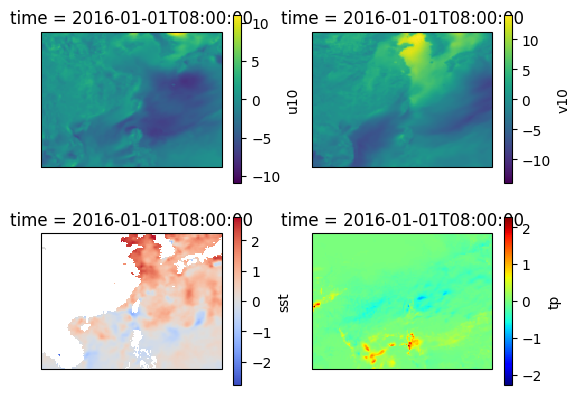

In [ ]:
# test
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': proj})
time_index = (local_ds_synoptic.time.dt.month==1)&(local_ds_synoptic.time.dt.day==1)&(local_ds_synoptic.time.dt.hour==8)
local_ds_synoptic.u10.sel(time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(ax=axes[0, 0], cmap='viridis')
local_ds_synoptic.v10.sel(time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(ax=axes[0, 1], cmap='viridis')
local_ds_synoptic.sst.sel(time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(ax=axes[1, 0], cmap='coolwarm')
local_ds_synoptic.tp.sel( time=time_index).sel(latitude=slice(40., 10.), longitude=slice(100., 140.)).plot(ax=axes[1, 1], cmap='jet')
plt.show()

**_<font color='E00000' size=7>part 11</font>_**

---

* **_<font face="Times New Roman" size=4>calculating diurnal cycle anomalies by subtracting monthly average value from hourly average values </font>_**

**_<font size=4>* diurnal_cycle_anomalies = hourly_mean - monthly_mean</font>_**

**_<font size=4>* this part will be skipped, since there's no data at a time resolution lower than the hourly scale.</font>_**

**_<font color='E00000' size=7>part 12</font>_**

---

* <font size=4>multiple subplots sharing the same x-axis with parameter </font>
 _<font face='Monospace' color='D434CD' size=4>sharex=True</font>_
 <font size=4> in </font>
 <font face='Monospace' color='D434CD' size=4>plt.subplots()</font>
 <font size=4> function/method. </font>

In [ ]:
ds_jan_ts = ds_jan.mean(dim=['latitude', 'longitude'])
ds_jan_ts_anom = ds_jan_ts - ds_jan_ts.mean(dim='time')

vlst = ['u10', 'v10', 'sst', 'tp']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 8.8), sharex=True)
for var, ax in zip(vlst, axes):
    ax.plot(ds_jan_ts_anom.time, ds_jan_ts_anom[var], linewidth=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

---
**_<center><font face="Times New Roman" size=7>---- the end ----</font></center>_**